<a href="https://colab.research.google.com/github/sandonli/Gecko-Binary-Classifier/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests, re, time
import torch, torchvision
from torch import nn, optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import argparse, imghdr, pickle, posixpath, re
import signal, socket, threading
import urllib.parse, urllib.request
import datetime, os, sys, logging, hashlib
from pathlib import Path
from os import listdir
from os.path import isfile, join

In [ ]:
!unzip Gecko-Binary-Classifier-main.zip

In [55]:
xform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Note - originally I had the datasets on my drive so that I wouldn't have to upload the datasets constantly. I have left the code below if you would like to run
# these tests on your own using google drive. For more information on running the binary classifier, see the "Training and Testing" section on the README for more details.
# from google.colab import drive
# drive.mount('/content/gdrive')
# dataset_full = datasets.ImageFolder('/content/gdrive/MyDrive/dataset', transform=xform)

dataset_full = datasets.ImageFolder('/content/Gecko-Binary-Classifier-main/dataset', transform=xform)

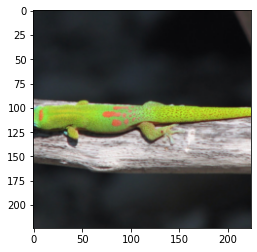

In [81]:
plt.imshow(dataset_full[978][0].permute(1,2,0))

In [76]:
n_all = len(dataset_full)
n_train = int(0.8 * n_all)
n_test = n_all - n_train
rng = torch.Generator().manual_seed(2000)
dataset_train, dataset_test = torch.utils.data.random_split(dataset_full, [n_train, n_test], rng)
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=4, shuffle=True)

In [77]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
torch.nn.init.xavier_uniform_(model.fc.weight)
device = torch.device('cuda:0')
model = model.to(device)

In [78]:
criterion = nn.CrossEntropyLoss()
mispredicts = []

def run_test(model):
  mispredicts = []
  nsamples_test = len(dataset_test)
  loss, correct = 0, 0
  model.eval()
  with torch.no_grad():
    for samples, labels in loader_test:
      samples = samples.to(device)
      labels = labels.to(device)
      outs = model(samples)
      loss += criterion(outs, labels)
      _, preds = torch.max(outs.detach(), 1)
      correct_mask = preds == labels
      correct += correct_mask.sum(0).item()
      if correct_mask.sum(0).item() != 1:
        mispredicts += samples
  return mispredicts, loss / nsamples_test, correct / nsamples_test

In [79]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [80]:
def run_train(model, opt, sched):
  nsamples_train = len(dataset_train)
  loss_sofar, correct_sofar = 0, 0
  model.train()
  with torch.enable_grad():
    for samples, labels in loader_train:
      samples = samples.to(device)
      labels = labels.to(device)
      opt.zero_grad()
      outs = model(samples)
      _, preds = torch.max(outs.detach(), 1)
      loss = criterion(outs, labels)
      loss.backward()
      opt.step()
      loss_sofar += loss.item() * samples.size(0)
      correct_sofar += torch.sum(preds == labels.detach())
  sched.step()
  return loss_sofar / nsamples_train, correct_sofar / nsamples_train

def run_all(model, optimizer, scheduler, n_epochs):
  for epoch in range(n_epochs):
    mispredicts = []
    loss_train, acc_train = run_train(model, optimizer, scheduler)
    mispredicts, loss_test, acc_test = run_test(model)
    print(f"epoch {epoch}: train loss {loss_train:.4f} acc { acc_train:.4f}, test loss {loss_test:.4f} acc {acc_test:.4f}")

In [ ]:
run_all(model, optimizer, scheduler, 8)